In [ ]:
import numpy as np
import sys
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator


# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import h5py
from typing import Tuple
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
from IPython.display import clear_output
from qiskit import QuantumCircuit, Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes
from qiskit.opflow import AerPauliExpectation, PauliSumOp
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit.algorithms.optimizers import L_BFGS_B,ADAM,GradientDescent
from qiskit.circuit import Parameter

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from mpl_toolkits.mplot3d import Axes3D
import math
import csv

# Data Processing for 1D Burger's Equation part

In [ ]:
number_of_samples = 2000
x= np.load('dataset/burgers_x'+'_'+str(number_of_samples)+'.npy')
t= np.load('dataset/burgers_t'+'_'+str(number_of_samples)+'.npy')
u= np.array(np.load('dataset/burgers_u'+'_'+str(number_of_samples)+'.npy'),dtype=np.float32).reshape(len(x),len(t))

In [ ]:
noise_level = 0.1
number_of_samples = 2000

In [ ]:
nn_shared_features = []
nn_specific_features = [65,65,65,65,1]

# learning parameters
deltaSP = 1e-5 # target MSE on test set before triggering sparsity for the first time
deltaC = 1e-2  # converge criterion
learning_rate = 5e-3
max_epochs = 1e5+1

In [ ]:
noise_l = noise_level*np.std(u)*np.random.randn(u.shape[0],u.shape[1])
u = u + noise_l

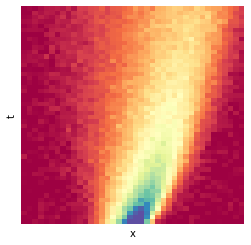

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

u1_noisy = u

bx = sns.heatmap(u1_noisy.T,ax=ax,vmin=0,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t');

In [ ]:
x_grid,  t_grid = np.meshgrid(x,  t, indexing="ij")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import shuffle,resample
from sklearn.linear_model import Ridge

In [ ]:
idx = resample(np.arange(u1_noisy.ravel().shape[0]),replace=False,random_state=44,n_samples=number_of_samples)

u1_noisy_shuffled = (u1_noisy.ravel())[idx]
xs = ((x_grid.ravel())[idx]).reshape(-1,1)
ts = ((t_grid).ravel()[idx]).reshape(-1,1)

In [ ]:
scale_from_outputs = []
u_d = []

# scaling and subsampling
u_sampled = u1_noisy_shuffled.reshape(-1,1)
u_max = u_sampled.max()
scale_from_outputs.append(u_max)
u_d.append(u_sampled/u_max)    

In [ ]:
# Data Normalization

X_data = np.concatenate([ts/t.max(),xs/x.max()],axis=1)
y_data = np.concatenate(u_d,axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

#  QNN Model Construction Part

### Model Components

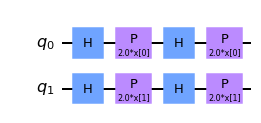

In [ ]:
# Feature map
# Data encoding
feature_map = ZFeatureMap(2)
feature_map.decompose().draw("mpl")

### Convolution Layer

In [ ]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

### Pooling layer

In [ ]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

### Model Construct

In [ ]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

feature_map = ZFeatureMap(2)

ansatz = QuantumCircuit(2, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(2, "с1"), list(range(2)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0], [1], "p1"), list(range(2)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(2, "c2"), list(range(2)), inplace=True)

# Second Pooling Layer
#ansatz.compose(pool_layer([0, 1], "p2"), list(range(1)), inplace=True)

# Third Convolutional Layer
#ansatz.compose(conv_layer(2, "c3"), list(range(2)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(2)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(2)
circuit.compose(feature_map, range(2), inplace=True)
circuit.compose(ansatz, range(2), inplace=True)

#observable = PauliSumOp.from_list([("Z" + "I" * 7, 1)])

# specify the observable
observable = PauliSumOp.from_list([("Z" * 2, 1)])

qnn = TwoLayerQNN(
    num_qubits=2,
    feature_map=feature_map,
    ansatz=ansatz,
    observable=observable,
    exp_val=AerPauliExpectation(),
    quantum_instance=quantum_instance,
)

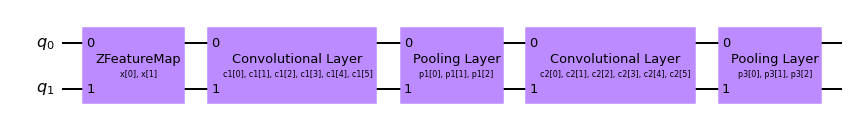

In [ ]:
circuit.draw("mpl")

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
circuit = QuantumCircuit(2)
circuit.compose(feature_map,  inplace=True)
circuit.compose(ansatz,  inplace=True)

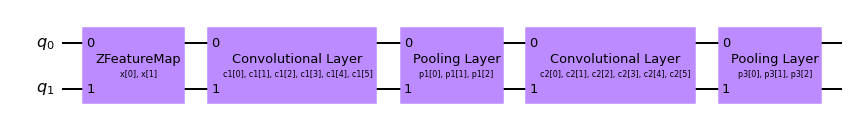

In [ ]:
circuit.draw('mpl')

In [ ]:
regressor = NeuralNetworkRegressor(
    neural_network=qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(),
    callback=callback_graph,
)

# Model Training Part

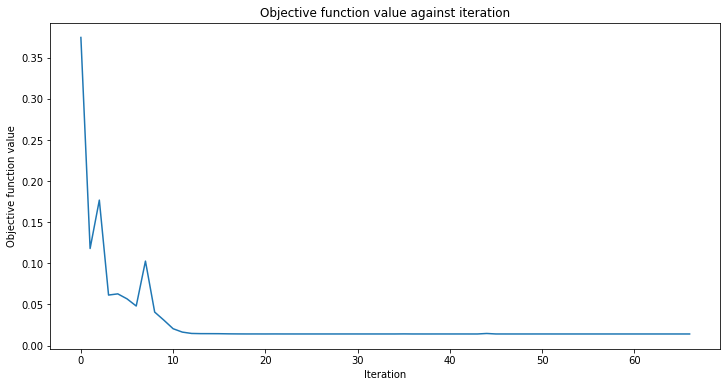

0.7948170381367301

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
regressor.fit(X_train, y_train)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
regressor.score(X_test, y_test)

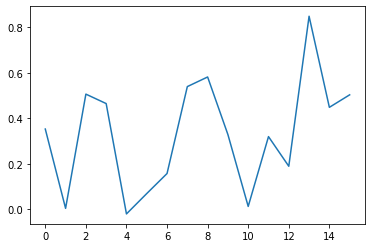

In [ ]:
plt.plot(y_test[:16])

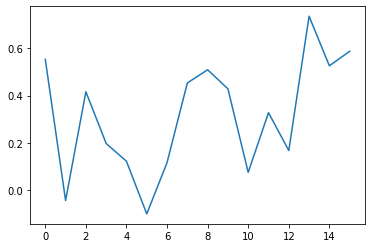

In [ ]:
plt.plot(regressor.predict(X_test[:16]))